In [42]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

## Pre-processing

In [2]:
df_hourly = pd.read_csv(os.getcwd() + '/Datasets/Ontario/Hourly_Electricity_Ontario.csv')

In [3]:
df_hourly['time'] = pd.to_datetime(df_hourly['time'])
numeric_columns = df_hourly.select_dtypes(include=['number']).columns
scaler = MinMaxScaler()
normalized_numeric_data = scaler.fit_transform(df_hourly[numeric_columns])
normalized_numeric_data = pd.DataFrame(normalized_numeric_data, columns=numeric_columns)
df_hourly[numeric_columns] = normalized_numeric_data
df_hourly = df_hourly[df_hourly['time'].dt.year != 2003]
df_hourly

,time,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_depth,cloud_cover,air_density,Total Energy Use from Electricity (MW)
8760,2004-01-01 00:00:00,0.000427,0.429819,0.000000,0.000000,0.000586,0.615678,0.132511,0.528899,0.502648
8761,2004-01-01 01:00:00,0.000299,0.424619,0.000000,0.000000,0.000586,0.615664,0.132711,0.537294,0.479483
8762,2004-01-01 02:00:00,0.000256,0.422102,0.000000,0.000000,0.000496,0.615653,0.148561,0.542783,0.457045
8763,2004-01-01 03:00:00,0.000256,0.419486,0.000000,0.000000,0.000451,0.615639,0.170830,0.548273,0.445118
8764,2004-01-01 04:00:00,0.000256,0.418112,0.000000,0.000000,0.000496,0.615628,0.204735,0.552793,0.442652
...,...,...,...,...,...,...,...,...,...,...
122731,2016-12-31 19:00:00,0.035032,0.455847,0.066136,0.321075,0.038099,0.605863,0.979035,0.446238,0.565595
122732,2016-12-31 20:00:00,0.039619,0.454278,0.029966,0.193530,0.038911,0.605963,0.975825,0.445915,0.541257
122733,2016-12-31 21:00:00,0.049540,0.449782,0.004875,0.043043,0.047568,0.606260,0.965694,0.449144,0.522539
122734,2016-12-31 22:00:00,0.052527,0.446070,0.000005,0.000031,0.052888,0.606921,0.938108,0.453342,0.504872


### Add the season column 
- Spring: March 1st to May 31st
- Summer: June 1st to August 31th
- Fall: September 1st to November 30th
- Winter: December 1st to February 28/29th
- Based on https://www.durhamimmigration.ca/en/moving-to-durham-region/weather---four-seasons.aspx

In [4]:
def season(date):
    month = date.month
    season = None
    if month in [3, 4, 5]:
        season = 'spring'
    elif month in [6, 7, 8]:
        season = 'summer'
    elif month in [9, 10, 11]:
        season = 'fall'
    elif month in [12, 1, 2]:
        season = 'winter'
    return season

# Separate the time column into dates and hour column 
df_hourly['dates'] = pd.to_datetime(df_hourly['time']).dt.date
df_hourly['hour'] = pd.to_datetime(df_hourly['time']).dt.hour

# Create the season column
df_hourly['season'] = df_hourly.apply(lambda x: season(x['dates']), axis=1)

In [5]:
# Drop the time column and reorder the order of the columns
df_hourly.drop(columns='time')
df_hourly = df_hourly[['dates', 'hour', 'season', 'precipitation', 'temperature', 'irradiance_surface', 
           'irradiance_toa', 'snowfall', 'snow_depth', 'cloud_cover', 'air_density', 'Total Energy Use from Electricity (MW)']]

In [6]:
df_hourly

,dates,hour,season,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_depth,cloud_cover,air_density,Total Energy Use from Electricity (MW)
8760,2004-01-01,0,winter,0.000427,0.429819,0.000000,0.000000,0.000586,0.615678,0.132511,0.528899,0.502648
8761,2004-01-01,1,winter,0.000299,0.424619,0.000000,0.000000,0.000586,0.615664,0.132711,0.537294,0.479483
8762,2004-01-01,2,winter,0.000256,0.422102,0.000000,0.000000,0.000496,0.615653,0.148561,0.542783,0.457045
8763,2004-01-01,3,winter,0.000256,0.419486,0.000000,0.000000,0.000451,0.615639,0.170830,0.548273,0.445118
8764,2004-01-01,4,winter,0.000256,0.418112,0.000000,0.000000,0.000496,0.615628,0.204735,0.552793,0.442652
...,...,...,...,...,...,...,...,...,...,...,...,...
122731,2016-12-31,19,winter,0.035032,0.455847,0.066136,0.321075,0.038099,0.605863,0.979035,0.446238,0.565595
122732,2016-12-31,20,winter,0.039619,0.454278,0.029966,0.193530,0.038911,0.605963,0.975825,0.445915,0.541257
122733,2016-12-31,21,winter,0.049540,0.449782,0.004875,0.043043,0.047568,0.606260,0.965694,0.449144,0.522539
122734,2016-12-31,22,winter,0.052527,0.446070,0.000005,0.000031,0.052888,0.606921,0.938108,0.453342,0.504872


In [7]:
df_hourly['season'].value_counts()

summer    28704
spring    28691
fall      28405
winter    28176
Name: season, dtype: int64

In [8]:
df_hourly['Total Energy Use from Electricity (MW)'].max()

0.9999999999999999

In [9]:
df_hourly['Total Energy Use from Electricity (MW)'].mean()

0.5754405681057279

In [10]:
df_hourly['Total Energy Use from Electricity (MW)'].min() ## too low

0.3311501920355771

In [11]:
df_hourly.isnull().sum() # no Nan cell

dates                                     0
hour                                      0
season                                    0
precipitation                             0
temperature                               0
irradiance_surface                        0
irradiance_toa                            0
snowfall                                  0
snow_depth                                0
cloud_cover                               0
air_density                               0
Total Energy Use from Electricity (MW)    0
dtype: int64

### Rule for merging hour -> daily
- max temp, 
- max snow depth (not reasonable)
- max snowfall
- max precip
- max irradiance
- max cloud coverage 
- max air density 
- sum all energy

In [12]:
df_daily = pd.read_csv(os.getcwd() + '/Datasets/Ontario/Daily_Electricity_Ontario.csv')

In [13]:
df_daily['time'] = pd.to_datetime(df_daily['time']).dt.date
df_daily['time'] = pd.to_datetime(df_daily['time'], format='%Y/%m/%d')
# Filter out rows with the year 2003
df_daily = df_daily[df_daily['time'].dt.year != 2003]
df_daily

,time,snow_depth,Total Energy Use from Electricity (MW),temperature,irradiance_surface,irradiance_toa,snowfall,cloud_cover,air_density,precipitation
365,2004-01-01,17.2316,363449,0.335,311.1307,542.9119,0.0608,0.9669,1.2908,0.0151
366,2004-01-02,17.2797,392163,3.126,202.3642,544.8137,1.0279,0.9959,1.2745,0.2762
367,2004-01-03,17.3078,377787,5.863,167.0140,546.8158,0.6193,0.9964,1.2442,1.0243
368,2004-01-04,17.3005,392135,2.157,183.1127,548.9446,0.3873,0.9734,1.2837,0.1739
369,2004-01-05,17.3234,460254,-3.564,179.3832,551.3384,2.6992,0.9688,1.2872,0.4115
...,...,...,...,...,...,...,...,...,...,...
5109,2016-12-27,17.1246,349744,6.067,202.2915,536.8441,0.5069,0.8070,1.2706,0.4975
5110,2016-12-28,16.8999,370750,-1.845,265.2472,537.9272,0.7057,0.9869,1.2887,0.0885
5111,2016-12-29,16.9279,370212,1.490,239.0488,539.3200,3.1252,0.9888,1.2737,0.5344
5112,2016-12-30,16.9282,368597,-0.869,233.1894,540.7564,1.7820,0.7623,1.2798,0.1649


In [14]:
df_daily['season'] = df_daily.apply(lambda x: season(x['time']), axis=1)
df_daily = df_daily[['time', 'season', 'precipitation', 'temperature', 'irradiance_surface', 
           'irradiance_toa', 'snowfall', 'snow_depth', 'cloud_cover', 'air_density', 'Total Energy Use from Electricity (MW)']]
df_daily

,time,season,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_depth,cloud_cover,air_density,Total Energy Use from Electricity (MW)
365,2004-01-01,winter,0.0151,0.335,311.1307,542.9119,0.0608,17.2316,0.9669,1.2908,363449
366,2004-01-02,winter,0.2762,3.126,202.3642,544.8137,1.0279,17.2797,0.9959,1.2745,392163
367,2004-01-03,winter,1.0243,5.863,167.0140,546.8158,0.6193,17.3078,0.9964,1.2442,377787
368,2004-01-04,winter,0.1739,2.157,183.1127,548.9446,0.3873,17.3005,0.9734,1.2837,392135
369,2004-01-05,winter,0.4115,-3.564,179.3832,551.3384,2.6992,17.3234,0.9688,1.2872,460254
...,...,...,...,...,...,...,...,...,...,...,...
5109,2016-12-27,winter,0.4975,6.067,202.2915,536.8441,0.5069,17.1246,0.8070,1.2706,349744
5110,2016-12-28,winter,0.0885,-1.845,265.2472,537.9272,0.7057,16.8999,0.9869,1.2887,370750
5111,2016-12-29,winter,0.5344,1.490,239.0488,539.3200,3.1252,16.9279,0.9888,1.2737,370212
5112,2016-12-30,winter,0.1649,-0.869,233.1894,540.7564,1.7820,16.9282,0.7623,1.2798,368597


In [15]:
df_daily['season'].value_counts()

spring    1196
summer    1196
fall      1183
winter    1174
Name: season, dtype: int64

## Exploratory Analysis

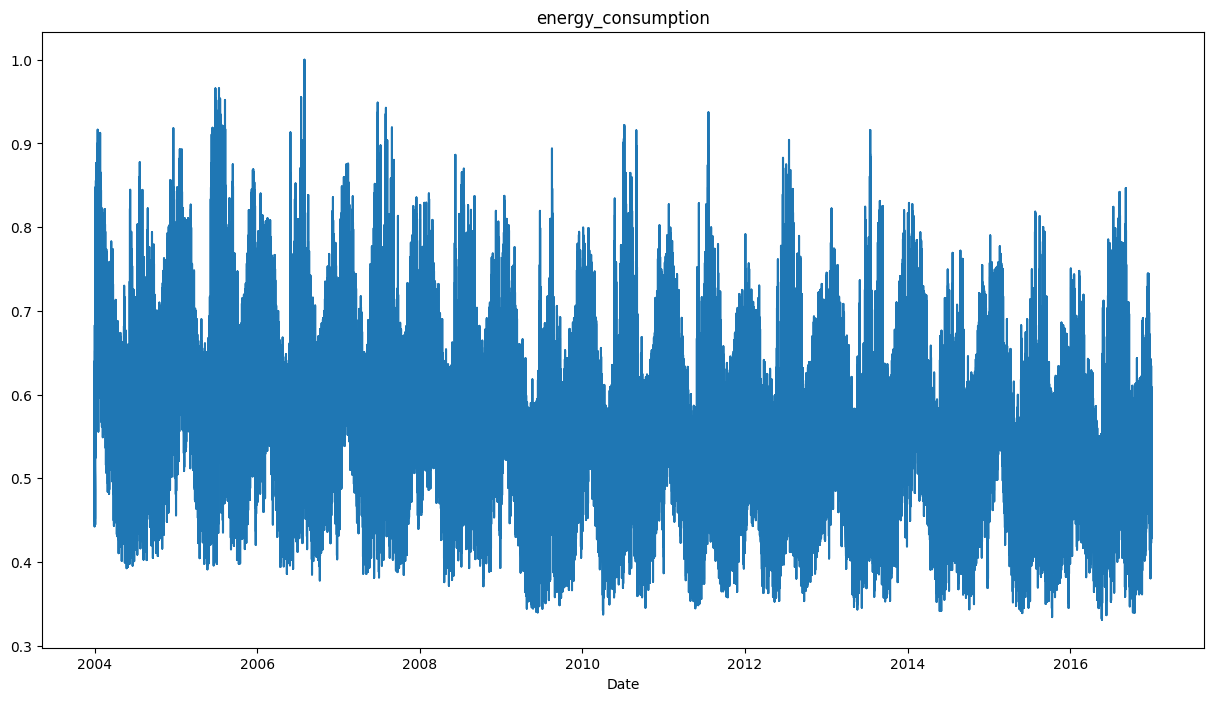

In [16]:
plt.figure(figsize=(15,8))
plt.title('energy_consumption')
plt.plot(df_hourly['dates'], df_hourly['Total Energy Use from Electricity (MW)'])
plt.xlabel('Date')
plt.show()

In [17]:
def get_period(df, start_date, end_date, col_name='dates'):
    df_start = df[df[col_name] >= pd.to_datetime(start_date)]
    return df_start[df_start[col_name] <= pd.to_datetime(end_date)]

In [18]:
start_date = '2016-01-01'
end_date = '2016-12-31'
df_2016 = get_period(df_hourly, start_date, end_date)
df_2016

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_71225/3640062300.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_start = df[df[col_name] >= pd.to_datetime(start_date)]
/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_71225/3640062300.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df_start[df_start[col_name] <= pd.to_datetime(end_date)]


,dates,hour,season,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_depth,cloud_cover,air_density,Total Energy Use from Electricity (MW)
113952,2016-01-01,0,winter,0.001941,0.402727,0.000000,0.000000,0.003021,0.634408,0.366837,0.552793,0.450657
113953,2016-01-01,1,winter,0.002368,0.401305,0.000000,0.000000,0.003968,0.634372,0.406962,0.553762,0.432505
113954,2016-01-01,2,winter,0.003286,0.403185,0.000000,0.000000,0.005501,0.634343,0.517504,0.553439,0.409339
113955,2016-01-01,3,winter,0.004694,0.406766,0.000000,0.000000,0.008161,0.634322,0.660949,0.553762,0.402587
113956,2016-01-01,4,winter,0.006529,0.407550,0.000000,0.000000,0.011362,0.634311,0.702879,0.555376,0.398059
...,...,...,...,...,...,...,...,...,...,...,...,...
122731,2016-12-31,19,winter,0.035032,0.455847,0.066136,0.321075,0.038099,0.605863,0.979035,0.446238,0.565595
122732,2016-12-31,20,winter,0.039619,0.454278,0.029966,0.193530,0.038911,0.605963,0.975825,0.445915,0.541257
122733,2016-12-31,21,winter,0.049540,0.449782,0.004875,0.043043,0.047568,0.606260,0.965694,0.449144,0.522539
122734,2016-12-31,22,winter,0.052527,0.446070,0.000005,0.000031,0.052888,0.606921,0.938108,0.453342,0.504872


In [19]:
start_date = '2015-01-01'
end_date = '2015-12-31'
df_2015 = get_period(df_hourly, start_date, end_date)
df_2015

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_71225/3640062300.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  df_start = df[df[col_name] >= pd.to_datetime(start_date)]
/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_71225/3640062300.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return df_start[df_start[col_name] <= pd.to_datetime(end_date)]


,dates,hour,season,precipitation,temperature,irradiance_surface,irradiance_toa,snowfall,snow_depth,cloud_cover,air_density,Total Energy Use from Electricity (MW)
105192,2015-01-01,0,winter,0.002262,0.328565,0.000000,0.000000,0.004779,0.620101,0.906911,0.642234,0.513038
105193,2015-01-01,1,winter,0.001856,0.327355,0.000000,0.000000,0.003923,0.620116,0.853847,0.639005,0.493471
105194,2015-01-01,2,winter,0.001771,0.323921,0.000000,0.000000,0.003742,0.620126,0.817835,0.638683,0.473378
105195,2015-01-01,3,winter,0.002027,0.319736,0.000000,0.000000,0.004283,0.620126,0.766175,0.640297,0.460885
105196,2015-01-01,4,winter,0.002198,0.317381,0.000000,0.000000,0.004644,0.620123,0.702377,0.640620,0.456721
...,...,...,...,...,...,...,...,...,...,...,...,...
113947,2015-12-31,19,winter,0.004523,0.446937,0.147037,0.320153,0.005816,0.634604,0.554720,0.534065,0.574732
113948,2015-12-31,20,winter,0.003307,0.440086,0.079395,0.192645,0.004328,0.634536,0.522720,0.537294,0.547039
113949,2015-12-31,21,winter,0.002283,0.424979,0.013211,0.042460,0.003336,0.634493,0.467449,0.541815,0.516596
113950,2015-12-31,22,winter,0.001813,0.412668,0.000004,0.000029,0.002886,0.634461,0.396930,0.546658,0.493026


In [20]:
def box_plot(df, by_type='hour'):
    fig = plt.figure()
    ax = df.boxplot(by=by_type, column='Total Energy Use from Electricity (MW)', figsize=(10, 6))
    plt.xlabel(f"{by_type} type")
    plt.ylabel("Total Energy Use from Electricity (MW)")
    ax.tick_params(axis='x', rotation=90)
    plt.show()

<Figure size 640x480 with 0 Axes>

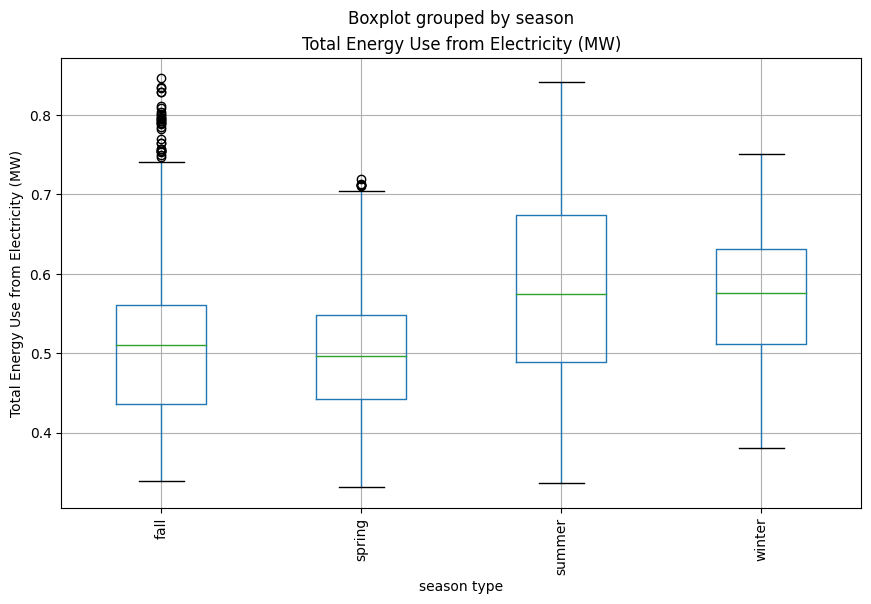

In [21]:
box_plot(df_2016, by_type='season')

<Figure size 640x480 with 0 Axes>

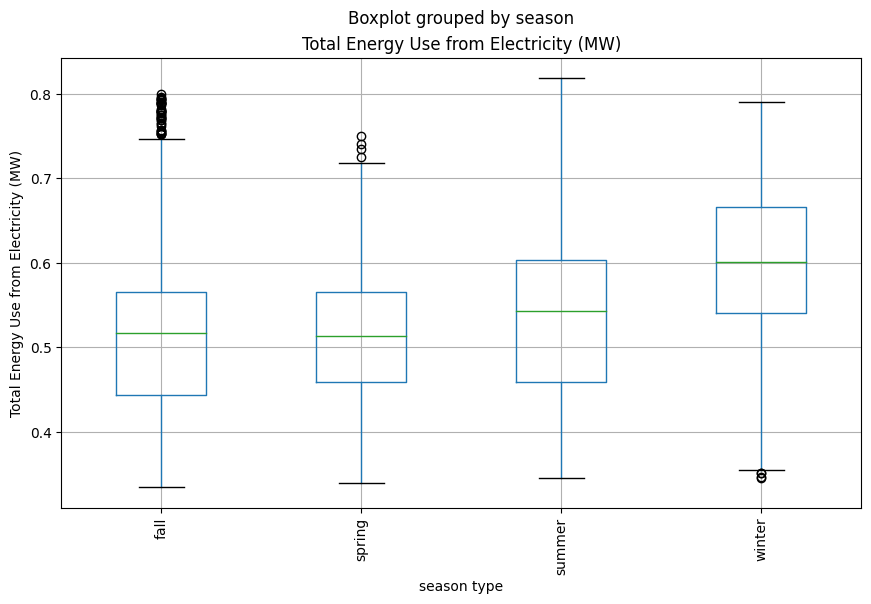

In [22]:
box_plot(df_2015, by_type='season')

In [23]:
def bar_plot(df, column_type='hour'):
    plt.figure(figsize=(12, 6))
    sns.barplot(x=column_type, y='Total Energy Use from Electricity (MW)', data=df, ci=None, estimator=sum)
    plt.title(f'{column_type}ly energy consumption')
    plt.xlabel(f'{column_type} of the day')
    plt.ylabel('Total Energy Consumption')
    plt.show()

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_71225/933044428.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=column_type, y='Total Energy Use from Electricity (MW)', data=df, ci=None, estimator=sum)


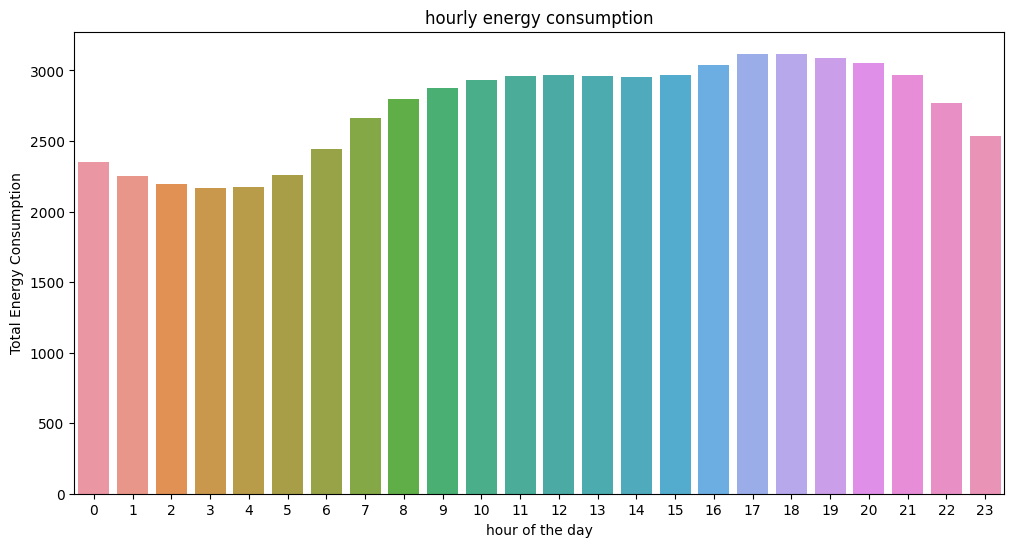

In [24]:
bar_plot(df_hourly)

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_71225/933044428.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=column_type, y='Total Energy Use from Electricity (MW)', data=df, ci=None, estimator=sum)


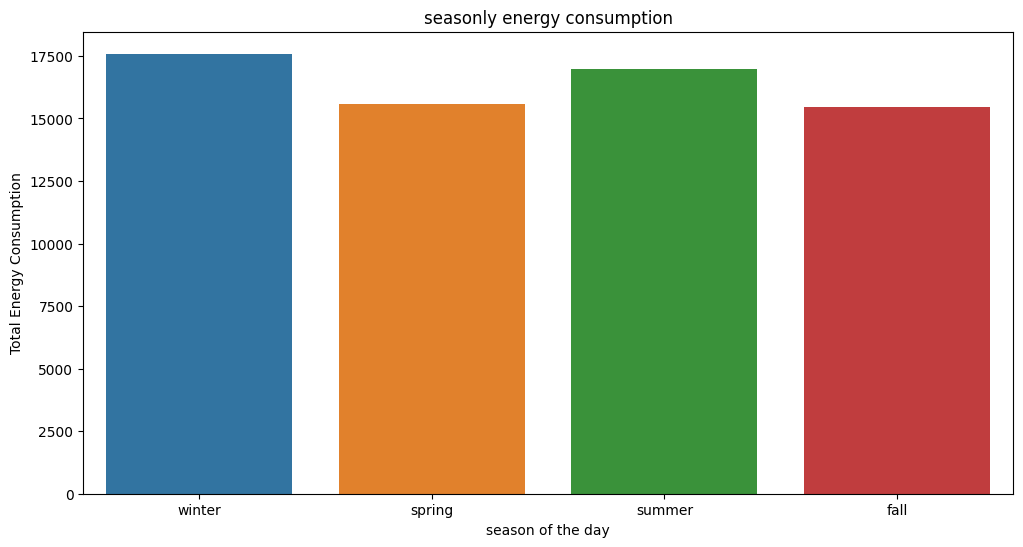

In [25]:
bar_plot(df_hourly, column_type='season')

In [26]:
df_hourly_test = df_hourly.copy()
df_hourly_test['month'] = pd.to_datetime(df_hourly['dates']).dt.month

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_71225/933044428.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=column_type, y='Total Energy Use from Electricity (MW)', data=df, ci=None, estimator=sum)


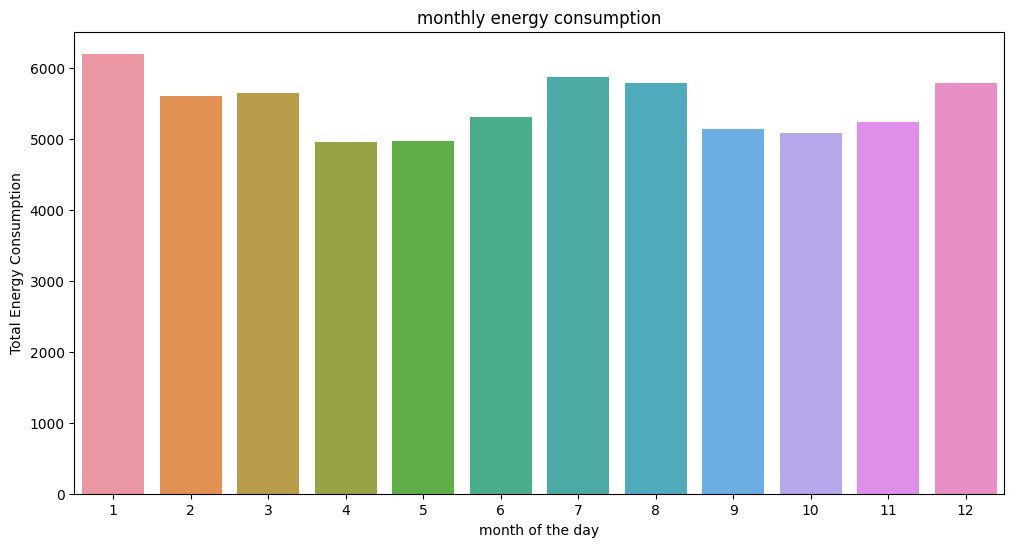

In [27]:
bar_plot(df_hourly_test, column_type='month')

Observation:

- January, December, July, August are the four months with highest energy consumption. 
- It can be explained by (Jan, Dec) - coldest months, (July, Aug) - hottest months

## Linear Regression/Decision Tree Regressor - ML Model

In [28]:
input_data = np.array(df_hourly.drop(columns=["dates", "hour", "season", "Total Energy Use from Electricity (MW)"]))
output_data = np.array(df_hourly["Total Energy Use from Electricity (MW)"])

In [29]:
# 0.3 -> 70% training data and 30% testing data
x_train, x_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.1)

# decision tree regressor model
tree = DecisionTreeRegressor().fit(x_train, y_train)
# linear regression model
lr = LinearRegression().fit(x_train, y_train)
# random forest
rf = RandomForestRegressor().fit(x_train, y_train)
# gradient boosting
gb = GradientBoostingRegressor().fit(x_train, y_train)

In [30]:
tree_prediction = tree.predict(x_test)
lr_prediction = lr.predict(x_test)
rf_prediction = rf.predict(x_test)
gb_prediction = gb.predict(x_test)

In [31]:
def plot_result(y_test, y_pred, df=None, model_type="Linear Regression", xlim_start=None, xlim_end=None):
    plt.figure(figsize=(12,7))
    plt.title(f'{model_type} Model')
    plt.xlabel('Days')
    plt.ylabel('Total Energy Use from Electricity (MW)')
    if df is not None:
        plt.plot(df['dates'], y_test, color="blue")
        plt.plot(df['dates'], y_pred, color="red")
    else:
        plt.plot(y_test, color="blue")
        plt.plot(y_pred, color="red")

    if xlim_start is not None and xlim_end is not None:
        plt.xlim(xlim_start, xlim_end)

    plt.show()

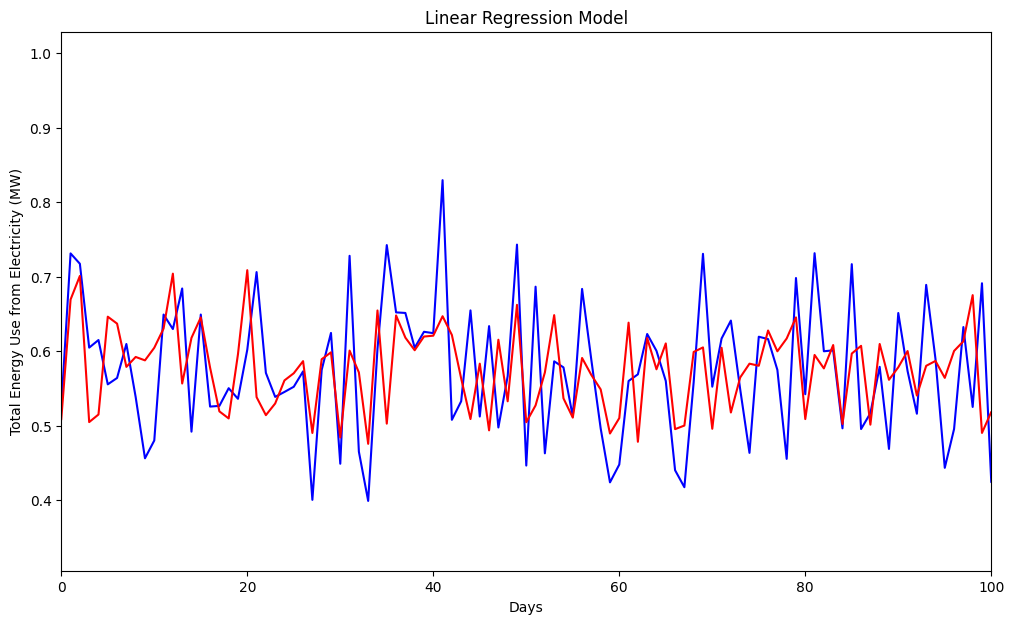

In [32]:
plot_result(y_test=y_test, y_pred=lr_prediction, xlim_start=0, xlim_end=100)

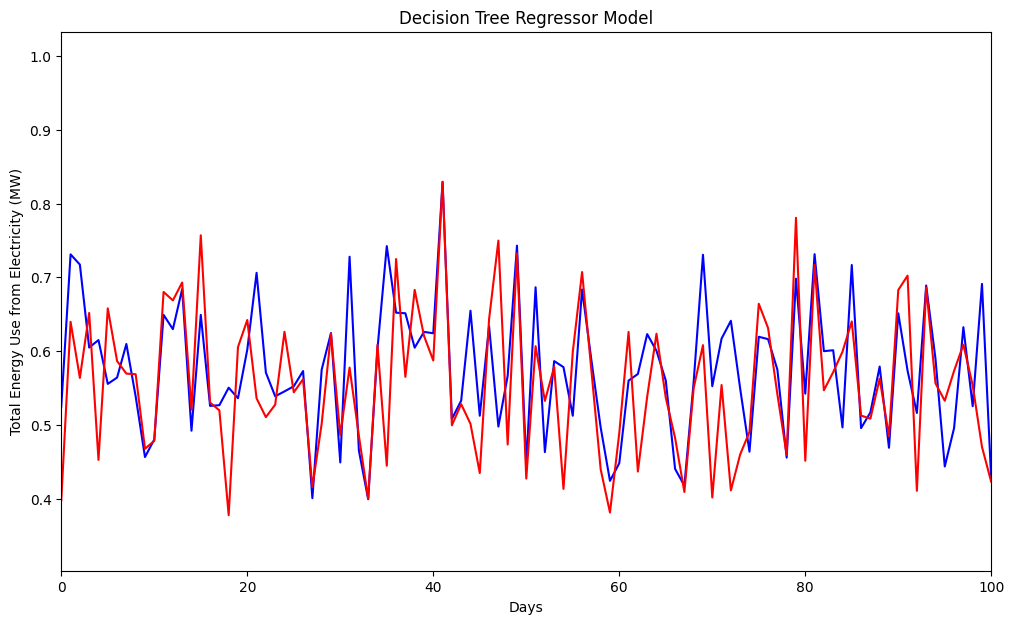

In [33]:
plot_result(y_test, tree_prediction, model_type="Decision Tree Regressor",xlim_start=0, xlim_end=100)

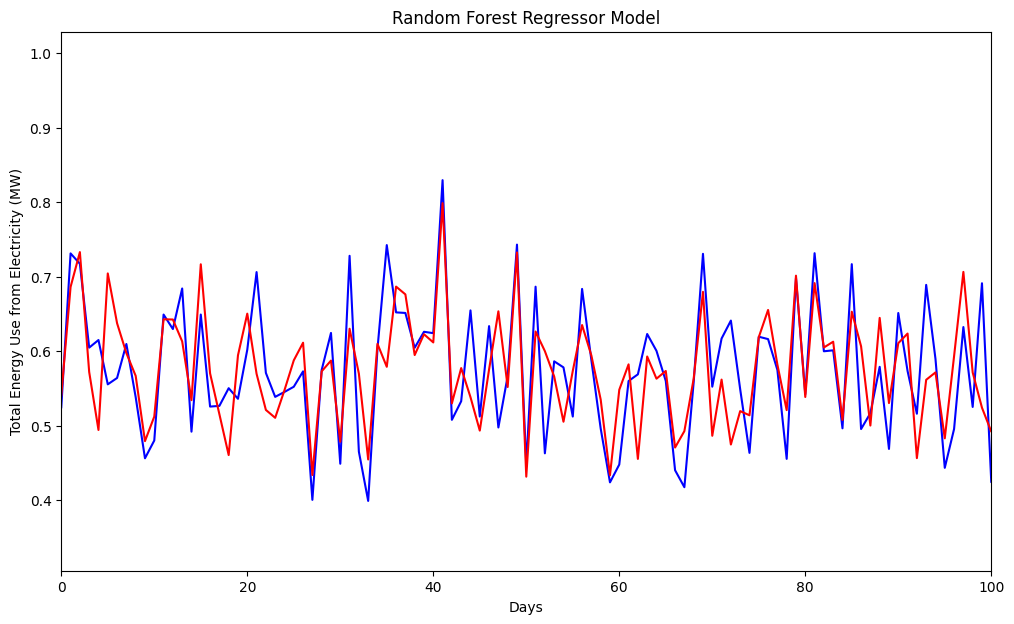

In [34]:
plot_result(y_test, rf_prediction, model_type="Random Forest Regressor",xlim_start=0, xlim_end=100)

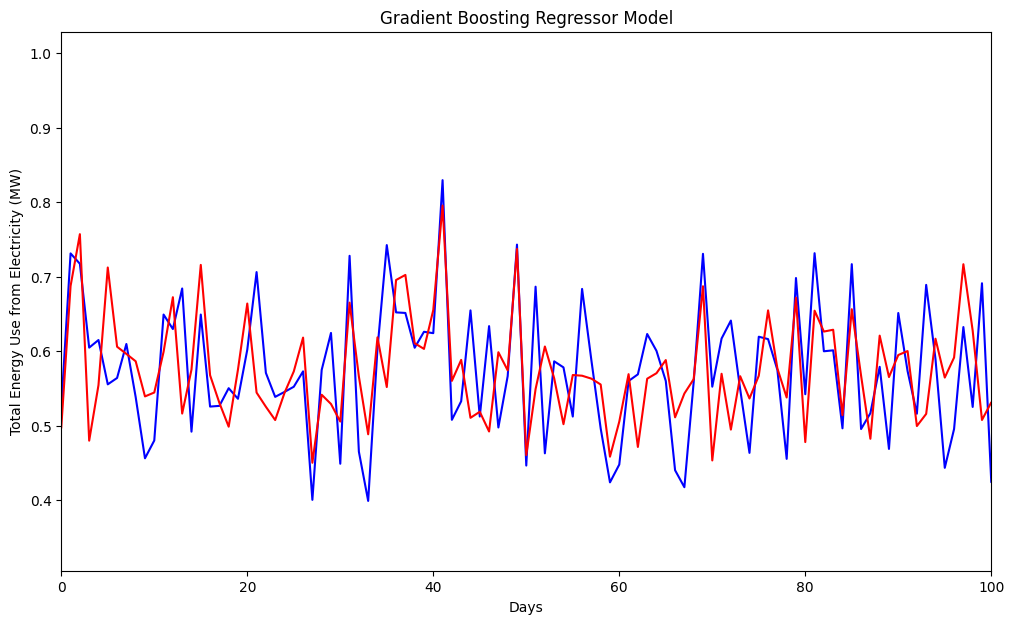

In [35]:
plot_result(y_test, gb_prediction, model_type="Gradient Boosting Regressor",xlim_start=0, xlim_end=100)

### Predict 2016 energy consumption

In [36]:
x_train = np.array(df_hourly[df_hourly['dates'] <= pd.Timestamp(2015, 12, 31)].drop(columns=["dates", "hour", "season", "Total Energy Use from Electricity (MW)"]))
y_train = np.array(df_hourly[df_hourly['dates'] <= pd.Timestamp(2015, 12, 31)]["Total Energy Use from Electricity (MW)"])

x_test = np.array(df_2016.drop(columns=["dates", "hour", "season", "Total Energy Use from Electricity (MW)"]))
y_test = np.array(df_2016["Total Energy Use from Electricity (MW)"])

/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_71225/2594482171.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  x_train = np.array(df_hourly[df_hourly['dates'] <= pd.Timestamp(2015, 12, 31)].drop(columns=["dates", "hour", "season", "Total Energy Use from Electricity (MW)"]))
/var/folders/sn/6brth5ks4z1gsf8wqvllhzz00000gn/T/ipykernel_71225/2594482171.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  y_train = np.array(df_hourly[df_hourly['dates'] <= pd.Timestamp(2015, 12, 31)]["Total Energy Use from Electricity (MW)"])


In [37]:
print('Training Features Shape (X_train):', x_train.shape)
print('Training Labels Shape (y_train):', y_train.shape)
print('Testing Features Shape (X_test):', x_test.shape)
print('Testing Labels Shape (y_test):', y_test.shape)

Training Features Shape (X_train): (105192, 8)
Training Labels Shape (y_train): (105192,)
Testing Features Shape (X_test): (8784, 8)
Testing Labels Shape (y_test): (8784,)


In [38]:
# decision tree regressor model
tree = DecisionTreeRegressor().fit(x_train, y_train)
# linear regression model
lr = LinearRegression().fit(x_train, y_train)
# random forest
rf = RandomForestRegressor().fit(x_train, y_train)
# gradient boosting
gb = GradientBoostingRegressor().fit(x_train, y_train)

In [39]:
tree_pred = tree.predict(x_test)
lr_pred = lr.predict(x_test)
rf_pred = rf.predict(x_test)
gb_pred = gb.predict(x_test)

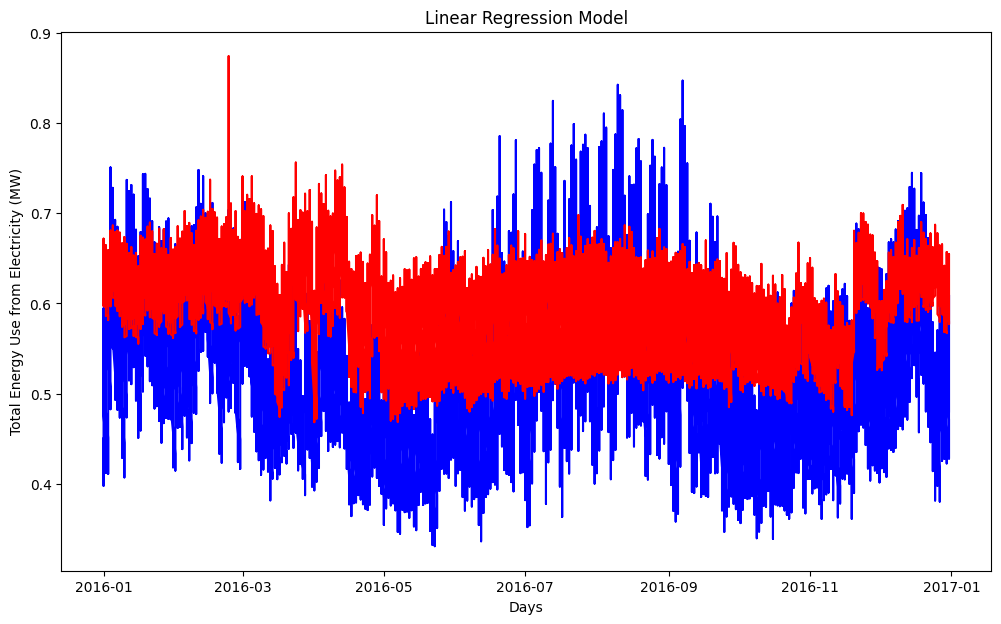

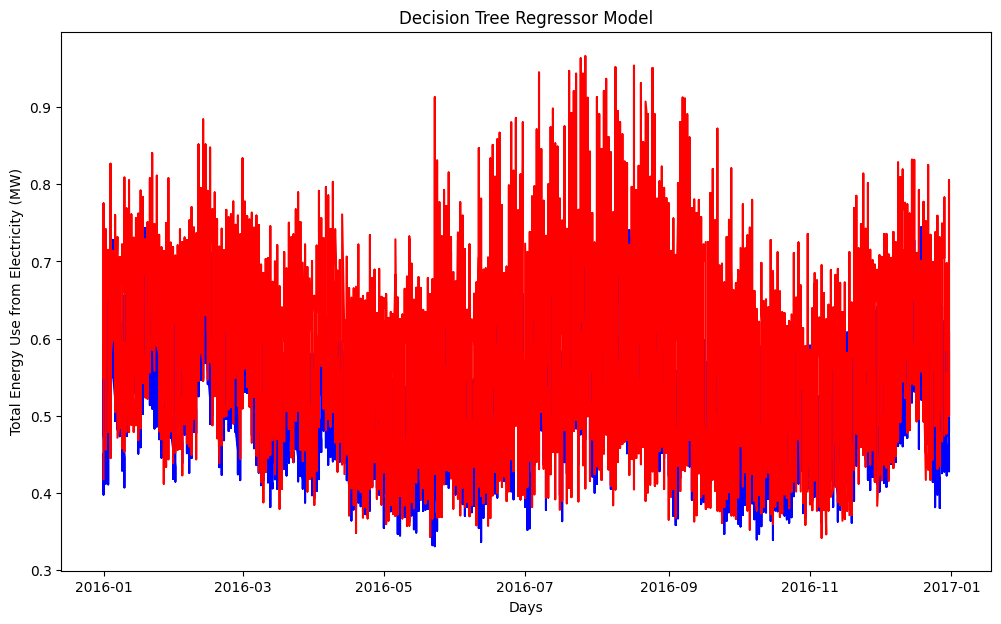

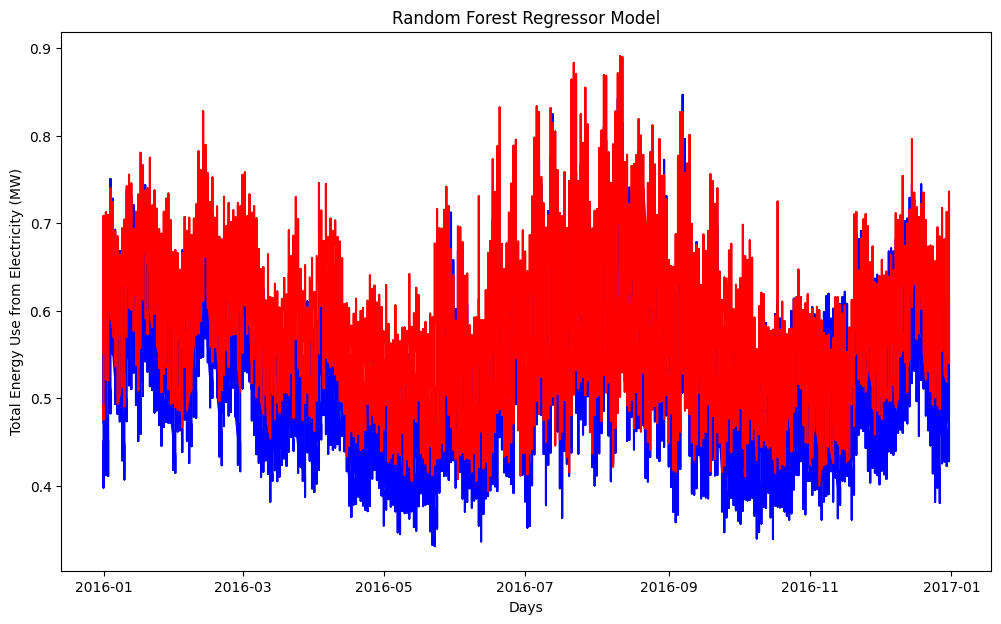

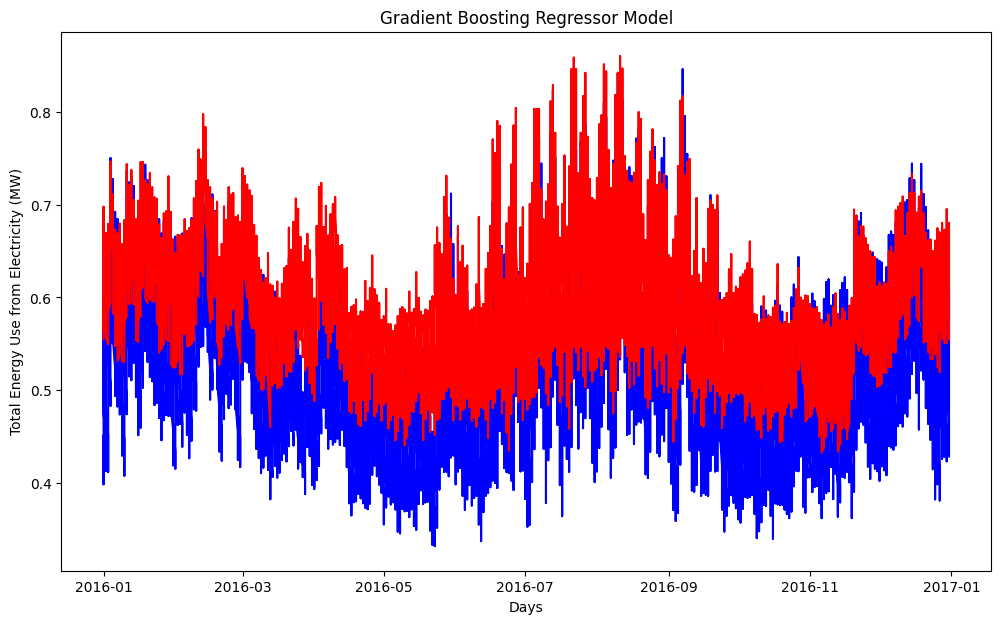

In [40]:
models = ['Linear Regression', "Decision Tree Regressor", "Random Forest Regressor", "Gradient Boosting Regressor"]
y_pred = [lr_pred, tree_pred, rf_pred, gb_pred]

for i in range(len(models)):
    plot_result(y_test, y_pred[i], df_2016, model_type=models[i])

In [43]:
for i in range(len(models)):
    mae = mean_absolute_error(y_test, y_pred[i])
    print(f'MAE = {mae} for {models[i]} model')

MAE = 0.07680323652753819 for Linear Regression model
MAE = 0.08139689635454579 for Decision Tree Regressor model
MAE = 0.06456902777823802 for Random Forest Regressor model
MAE = 0.06547649117721661 for Gradient Boosting Regressor model


- Best model so far - Random Forest Regressor
- Further investigation by finding the best **hyper-parameter** for the **Random Forest Regressor**

In [44]:
# Number of folds
k = 5

# Models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor()
}

# Combined input and output data
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Perform cross-validation and calculate the mean absolute error (MAE) for each model
for model_name, model in models.items():
    mae_scores = -cross_val_score(model, x, y, cv=k, scoring='neg_mean_absolute_error')
    mean_mae = np.mean(mae_scores)
    print(f'Mean MAE for {model_name}: {mean_mae}')

Mean MAE for Linear Regression: 0.07319143323434088
Mean MAE for Decision Tree Regressor: 0.08201672102878925
Mean MAE for Random Forest Regressor: 0.06270822767353572
Mean MAE for Gradient Boosting Regressor: 0.06359807164922554
